***DIFFERENCES WITH RESPECT TO PREVIOUS NOTEBOOK***

In this notebook we're going to apply the same process as before, but considering the whole dataset (instead of relevant features only). 

In conclusion, we'll see if there are any advantages in computing or not the Mutual Information, comparing the results of tree-based models.

***1) DATA PRE-PROCESSING***

In this section we're going to analyze our dataset and apply suitable data pre-processing operations.

First of all, a conversion of nominal features into numerical ones was performed.

Then, a search of missing values was performed, dropping those rows containing them.

Next, a type conversion was needed in order to work with a single type for all possible delays.

Finally, a rename operation was performed in order to obtain a simpler way to represent that column.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
# Dataset loading and converted in csv
df = pd.read_excel('/kaggle/input/customer-satisfaction/satisfaction.xlsx')
df.to_csv('/kaggle/working/satisfaction.csv', index=False)

In [4]:
# Dataset loading
df = pd.read_csv('/kaggle/working/satisfaction.csv') 

print("Number of initial rows: ", df.shape[0])
print("\n", df.head())

Number of initial rows:  129880

        id satisfaction_v2  Gender   Customer Type  Age   Type of Travel  \
0   11112       satisfied  Female  Loyal Customer   65  Personal Travel   
1  110278       satisfied    Male  Loyal Customer   47  Personal Travel   
2  103199       satisfied  Female  Loyal Customer   15  Personal Travel   
3   47462       satisfied  Female  Loyal Customer   60  Personal Travel   
4  120011       satisfied  Female  Loyal Customer   70  Personal Travel   

      Class  Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0       Eco              265             0                                  0   
1  Business             2464             0                                  0   
2       Eco             2138             0                                  0   
3       Eco              623             0                                  0   
4       Eco              354             0                                  0   

   ...  Online support  Ease

In [5]:
# Conversion of nominal features into numerical ones
# (needed also because after pre-processing step Mutual Information works with numbers)
label_encoders = {}
for column in df.columns:
    if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
        
print(df.head())

       id  satisfaction_v2  Gender  Customer Type  Age  Type of Travel  Class  \
0   11112                1       0              0   65               1      1   
1  110278                1       1              0   47               1      0   
2  103199                1       0              0   15               1      1   
3   47462                1       0              0   60               1      1   
4  120011                1       0              0   70               1      1   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  ...  \
0              265             0                                  0  ...   
1             2464             0                                  0  ...   
2             2138             0                                  0  ...   
3              623             0                                  0  ...   
4              354             0                                  0  ...   

   Online support  Ease of Online booking  On-board serv

In [6]:
# Look for the number of missing values in each column
missing_values = df.isnull().sum()
print("Number of missing values per column: \n", missing_values)

Number of missing values per column: 
 id                                     0
satisfaction_v2                        0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in M

As shown, only 'Arrival Delay in Minutes' feature has missing values.
Since its value could depend on different factor in the real life, it was chosen to drop those rows containing them, also considering they're quite few.

In [7]:
# Drop those rows
df = df.dropna()
print("Number of rows after dropping missing values: ", df.shape[0])

Number of rows after dropping missing values:  129487


In [8]:
# Usage of a single type per delay
print("Departure Delay in Minutes type (before): ", df['Departure Delay in Minutes'].dtype)
print("Arrival Delay in Minutes type (before): ", df['Arrival Delay in Minutes'].dtype)

df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].astype('int', )

print("Departure Delay in Minutes type (after): ", df['Departure Delay in Minutes'].dtype)
print("Arrival Delay in Minutes type (after): ", df['Arrival Delay in Minutes'].dtype)

Departure Delay in Minutes type (before):  int64
Arrival Delay in Minutes type (before):  float64
Departure Delay in Minutes type (after):  int64
Arrival Delay in Minutes type (after):  int64


In [9]:
# Renaming of satisfaction (for semplicity)
df.rename(columns={'satisfaction_v2': 'Satisfaction'}, inplace=True)

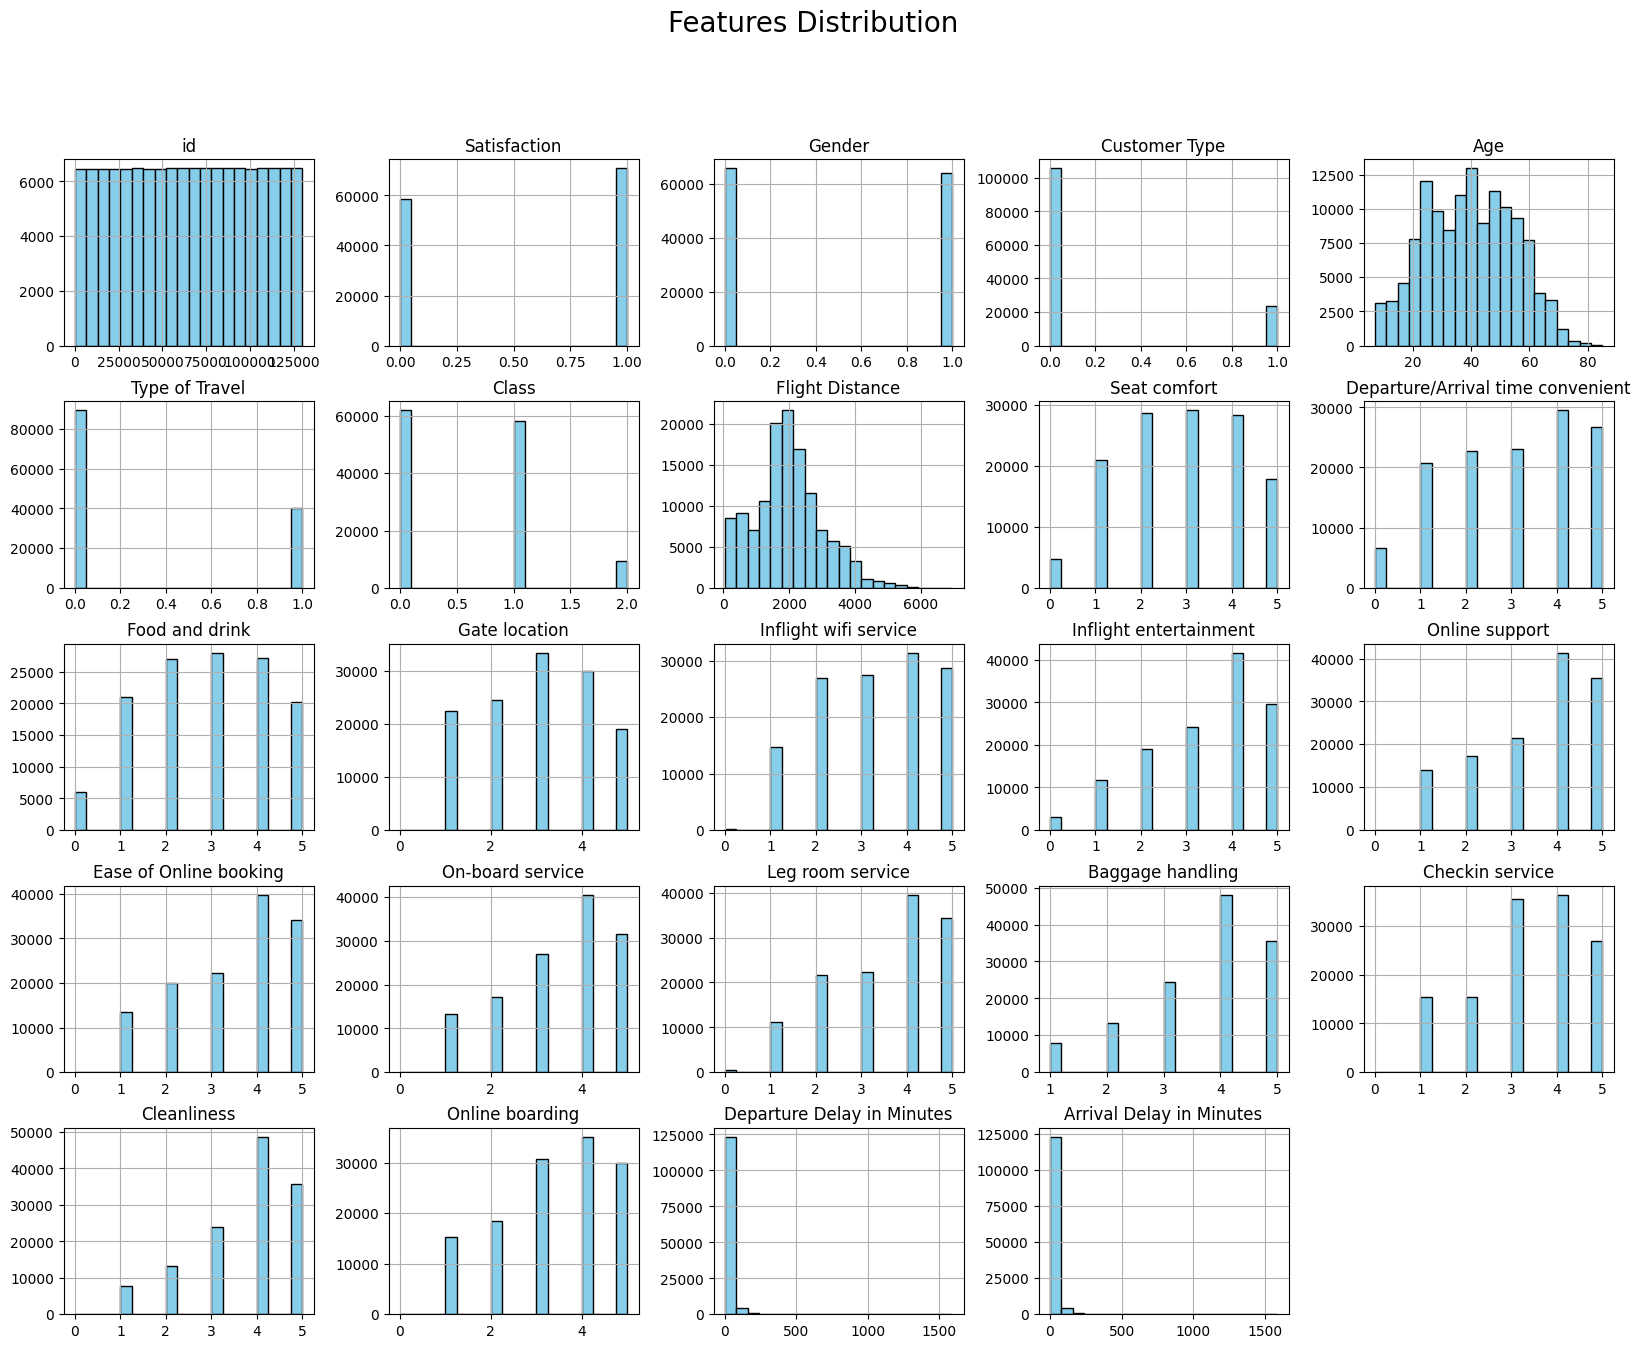

In [10]:
# Visualization of features distribution
df.hist(figsize=(20, 15), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Features Distribution', fontsize=20)
plt.show()

As shown, the target class 'Satisfaction' is quite balanced. Then, different factors are considered while providing an opinion of the overall airline passenger's satisfaction. Moreover, taking into account all the 129k surveys, in almost all cases delays were recorded as 0 minutes, indicating that the majority of flights arrived on time.

In [11]:
# Saving of modifications applied
df.to_csv('/kaggle/working/PassengerSatisfaction(afterPreProc).csv', index=False)

Now we do not apply Mutual Information, but we're going to consider the entire dataset.

In [12]:
# Features and target one splitting
X = df.drop('Satisfaction', axis=1)
y = df['Satisfaction']

***2) PERFORMANCES EVALUATION AND MODELS COMPARISON***

Finally, we want to use the best models defined in the pervious notebook (Decision Tree and Random Forest), and exploit their tuned hyperparameters in order to fit and evaluate them through Confusion Matrics, Precision-Recall and ROC curves.

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [14]:
# Training-Test sets splitting (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Starting Grid Search for Decision Tree...
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 15}


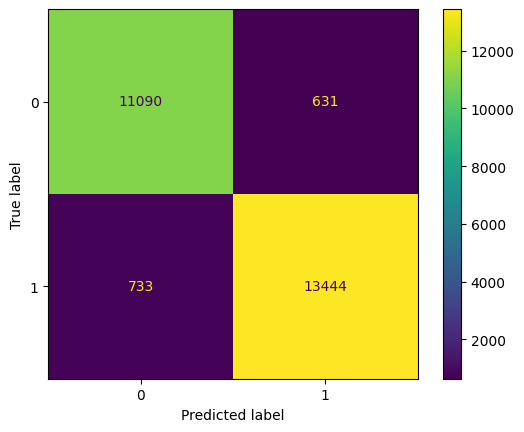

In [15]:
# Decision Tree GridSearch with model fitting
print("Starting Grid Search for Decision Tree...")

dt_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(),
                              param_grid={
                                  'max_depth': [None, 10, 15],
                                  'criterion': ['gini', 'entropy']
                              },
                              cv=None,  # k=5 stratified K-Fold CV (following doc)
                              scoring='accuracy',
                              n_jobs=-1)

dt_grid_search.fit(X_train, y_train) # it will represent our decision tree model
print(f"Best parameters for Decision Tree: {dt_grid_search.best_params_}")

# Confusion Matrix visualization
dt_pred_test = dt_grid_search.predict(X_test)
cm_dt_test = confusion_matrix(y_test, dt_pred_test)
ConfusionMatrixDisplay(cm_dt_test).plot()
plt.show()

Interpretation:
- True Negatives (TN): The model correctly predicted 11,090 samples as 0 (negative class) and their true value was indeed 0.

- False Positives (FP): The model predicted 1 (positive class) for 631 samples that were actually 0. This is an error because the model misclassified some samples as positive.

- False Negatives (FN): The model predicted 0 (negative class) for 733 samples that were actually 1. This is an error because the model failed to recognize these samples as positive.

- True Positives (TP): The model correctly predicted 13,444 samples as 1 (positive class) and their true value was indeed 1.

Starting Grid Search for Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 50}


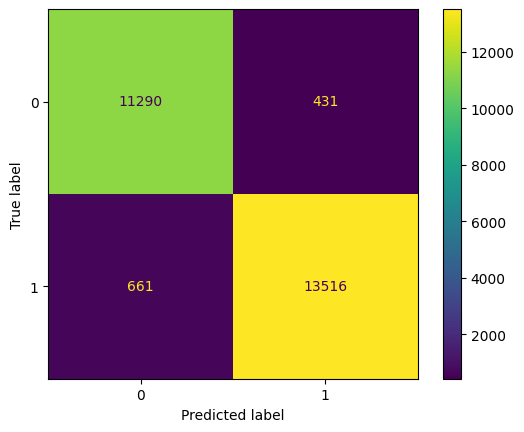

In [16]:
# Random Forest GridSearch with model fitting
print("Starting Grid Search for Random Forest...")

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(),
                              param_grid={
                                  'n_estimators': [15, 30, 50],
                                  'max_depth': [None, 10, 15]
                              },
                              cv=5,  # Usa una cross-validation k=5
                              scoring='accuracy',
                              n_jobs=-1)

rf_grid_search.fit(X_train, y_train) # it will represent our random forest model
print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")

# Confusion Matrix visualization
rf_pred_test = rf_grid_search.predict(X_test)
cm_rf_test = confusion_matrix(y_test, rf_pred_test)
ConfusionMatrixDisplay(cm_rf_test).plot()
plt.show()

Interpretation:
- True Negatives (TN): The model correctly predicted 11,290 samples as 0 (negative class) and their true value was indeed 0.

- False Positives (FP): The model predicted 1 (positive class) for 431 samples that were actually 0. This is an error because the model misclassified some samples as positive.

- False Negatives (FN): The model predicted 0 (negative class) for 661 samples that were actually 1. This is an error because the model failed to recognize these samples as positive.

- True Positives (TP): The model correctly predicted 13,516 samples as 1 (positive class) and their true value was indeed 1.

Looking at both confusion matrices compared we can say that:

The number of False Positives (incorrect predictions of class 1 when it was 0) is slightly better for Random Forest (431) compared to Decision Tree (631).

The number of False Negatives (incorrect predictions of class 0 when it was 1) is slightly better for Random Forest (611) compared to Decision Tree (733).

Random Forest has slightly more True Positives (13,516 compared to 13,444 for Decision Tree), which suggests that Random Forest has a slight advantage in recognizing positive samples compared to the Decision Tree.

Therefore, overall, Random Forest seems to perform slightly better at correctly recognizing positive class samples compared to the Decision Tree.

Now we're going to visualize ROC and Precision-recall curves exploiting their functionalities and then ending the comparison between the two models.

In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

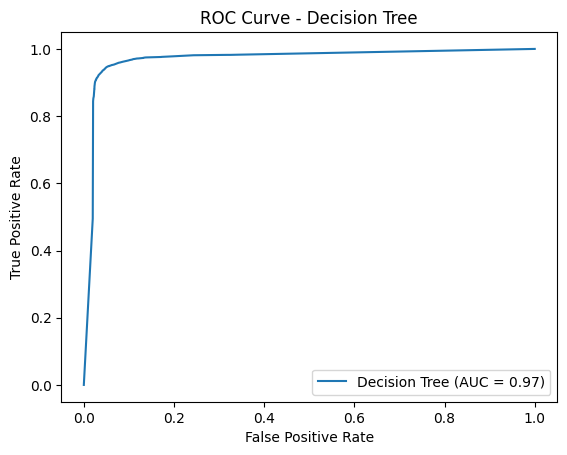

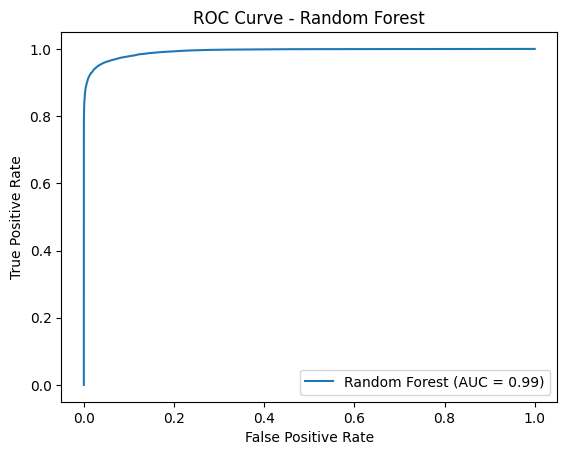

In [18]:
# Decision Tree ROC Curve
dt_prob_test = dt_grid_search.predict_proba(X_test)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_prob_test)
roc_auc_dt = auc(fpr_dt, tpr_dt) # area defining the model ability to distinguish classes

# Visualization
RocCurveDisplay(fpr=fpr_dt, tpr=tpr_dt, roc_auc=roc_auc_dt, estimator_name='Decision Tree').plot()
plt.title('ROC Curve - Decision Tree')
plt.show()


# Random Forest ROC Curve
rf_prob_test = rf_grid_search.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob_test)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Visualization
RocCurveDisplay(fpr=fpr_rf, tpr=tpr_rf, roc_auc=roc_auc_rf, estimator_name='Random Forest').plot()
plt.title('ROC Curve - Random Forest')
plt.show()

When interpreting ROC curves, the ideal curve would be positioned as close as possible to the top-left corner of the plot. This indicates a high True Positive Rate (sensitivity) and a low False Positive Rate (specificity).

Computing the various probabilities allows us to change the decision threshold of the model (the default is 50% - meaning that if a sample belongs to a class with a probability greater than that threshold, then it belongs to that class for sure), and visualize any possible situation the model could achieve.

In our analysis, both models exhibited quite good performance across all possible thresholds. Nevertheless, Random Forest proved to be slightly better than Decision Tree, and this could be visualized by the next comparison of the two curves.

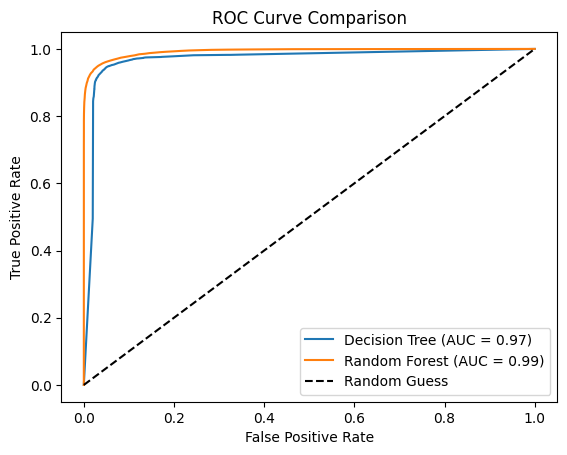

In [19]:
# Comparison between the two ROC curves
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.show()

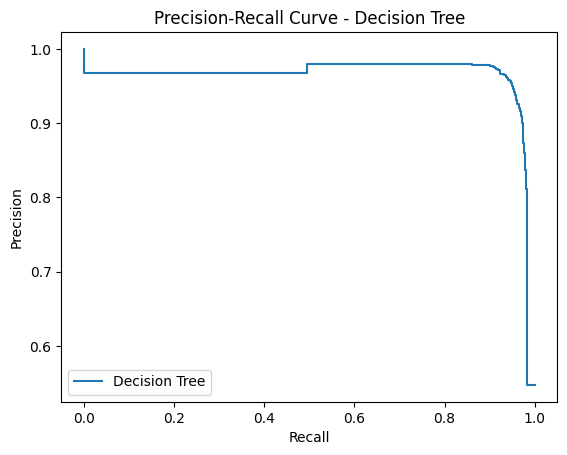

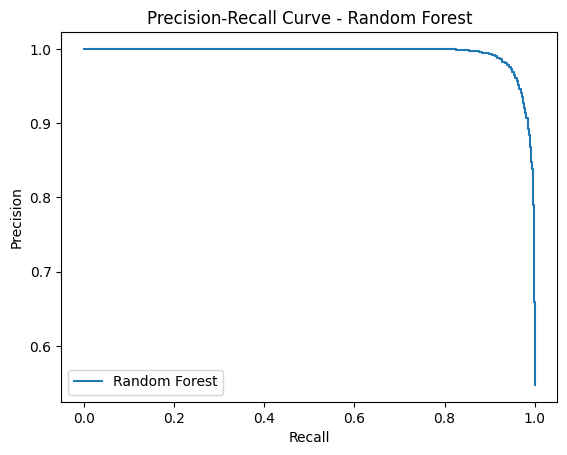

In [20]:
# Decision Tree Precision-Recall curve
precision_dt, recall_dt, _ = precision_recall_curve(y_test, dt_prob_test)

# Visualization
PrecisionRecallDisplay(precision=precision_dt, recall=recall_dt, estimator_name='Decision Tree').plot()
plt.title('Precision-Recall Curve - Decision Tree')
plt.show()


# Random Forest Precision-Recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_prob_test)

# Visualization
PrecisionRecallDisplay(precision=precision_rf, recall=recall_rf, estimator_name='Random Forest').plot()
plt.title('Precision-Recall Curve - Random Forest')
plt.show()

When evaluating models using Precision-Recall curves, the goal is to maximize both Precision and Recall. Therefore, the ideal curve would be positioned as close as possible to the top-right corner of the plot.

As with the ROC curve analysis, also here the Random Forest model is proved to be better than the Decision Tree. The next visualization will compare both of them.

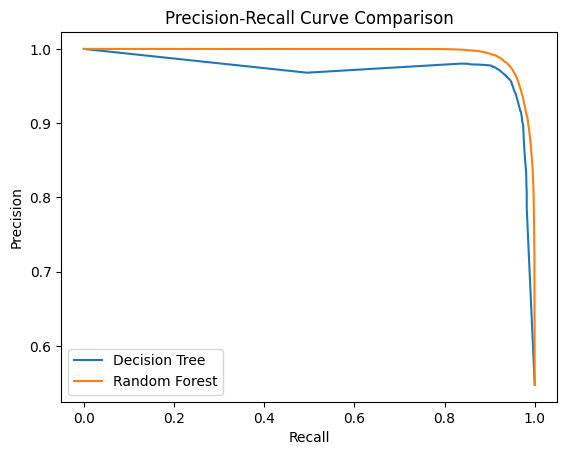

In [21]:
# Comparison between the two Precision-Recall curves
plt.plot(recall_dt, precision_dt, label='Decision Tree')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.show()

***3) CONCLUSIONS***

In conclusion, our analysis indicates that considering relevant features only will lead to performances that are slightly worse than those we would have while considering the whole dataset. 

Moreover, if we take into account the entire dataset we would prefer the Random Forest, instead of the Decision Tree, due to its evident superior capability of capturing data distribution.